In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.preprocessing import StandardScaler

# --- 1. Load and Prepare Data ---
# Load both datasets
good_df = pd.read_csv('/content/2good_reqff.csv')
bad_df = pd.read_csv('/content/2bad_reqff.csv')

# Define the features to be used
feature_cols = ['path_length', 'body_length', 'badwords_count']

# Create the training data using ONLY good requests
X_train_good = good_df[feature_cols].values

# Combine all data for testing later
combined_df = pd.concat([good_df, bad_df], ignore_index=True)
X_all = combined_df[feature_cols].values

# Scale the features. It's crucial to fit the scaler ONLY on the good data.
scaler = StandardScaler()
X_train_good_scaled = scaler.fit_transform(X_train_good)
X_all_scaled = scaler.transform(X_all) # Apply the same scaling to all data

# --- 2. Build and Train the Autoencoder ---
autoencoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=2, activation='relu', input_shape=(X_all_scaled.shape[1],)),
  tf.keras.layers.Dense(units=X_all_scaled.shape[1], activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError())


# Train the model on the scaled GOOD data
autoencoder.fit(X_train_good_scaled, X_train_good_scaled, epochs=20, batch_size=32, shuffle=True, verbose=0)

autoencoder.save("model.h5")
print("Model saved to model.h5")

joblib.dump(scaler, "scaler.pkl")

# --- 3. Generate Anomaly Scores ---
# Get the model's reconstructions of ALL data
reconstructions = autoencoder.predict(X_all_scaled)

# Calculate the Mean Absolute Error between the original and reconstructed data
# This error is our anomaly score
anomaly_scores_ae = np.mean(np.abs(X_all_scaled - reconstructions), axis=1)

# Add the scores to our combined dataframe
combined_df['anomaly_score_autoencoder'] = anomaly_scores_ae

print("Data with Autoencoder Anomaly Scores:")
print(combined_df.head())
print("\nSample of scores from the end of the file (bad requests):")
print(combined_df.tail())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model saved to model.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Data with Autoencoder Anomaly Scores:
  method                    path body  single_q  double_q  dashes  braces  \
0    GET                       /  NaN         0         0       0       0   
1    GET             /robots.txt  NaN         0         0       0       0   
2    GET              /style.css  NaN         0         0       0       0   
3    GET        /images/logo.gif  NaN         0         0       0       0   
4    GET  /images/header_pic.jpg  NaN         0         0       0       0   

   spaces  percentages  semicolons  angle_brackets  special_chars  \
0       0            0           0               0              0   
1       0            0           0               0              0   
2       0            0           0               0              0   
3       0            0           0               0              0   
4       0            0           0               0              0   

   path_length  bod

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# --- 1. Choose your threshold based on the plot ---
threshold = 1.2

# --- 2. Apply the threshold to get final predictions ---
# If score > threshold, it's an anomaly (1), otherwise it's normal (0)
combined_df['prediction'] = (combined_df['anomaly_score_autoencoder'] > threshold).astype(int)

# Create the true labels for comparison (bad=1, good=0)
combined_df['true_label'] = (combined_df['class'] == 'bad').astype(int)

# --- 3. Calculate Final Metrics ---
# Generate the confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['true_label'], combined_df['prediction']).ravel()

print(f"Threshold set to: {threshold}")
print(f"True Negatives (Good logs identified as Good): {tn}")
print(f"False Positives (Good logs flagged as Bad): {fp}")
print(f"False Negatives (Bad logs missed): {fn}")
print(f"True Positives (Bad logs caught): {tp}")

# False Positive Rate (FPR) -> Your project goal is <5%
fpr = fp / (fp + tn)
print(f"\nFalse Positive Rate: {fpr:.2%}")

# Accuracy -> Overall correctness
accuracy = accuracy_score(combined_df['true_label'], combined_df['prediction'])
print(f"Accuracy: {accuracy:.2%}")

# Detection Rate (Recall) -> Percentage of bad logs you successfully caught
detection_rate = tp / (tp + fn)
print(f"Detection Rate (Recall): {detection_rate:.2%}")

Threshold set to: 1.2
True Negatives (Good logs identified as Good): 278
False Positives (Good logs flagged as Bad): 9
False Negatives (Bad logs missed): 1419
True Positives (Bad logs caught): 4091

False Positive Rate: 3.14%
Accuracy: 75.37%
Detection Rate (Recall): 74.25%


In [22]:
AUTOENCODER_PATH = "model.h5"
GOOD_CSV = "2good_reqff.csv"
BAD_CSV = "2bad_reqff.csv"
SCALER_PATH = "scaler.pkl"
scaler = joblib.load(SCALER_PATH)

# Load data

df_good = pd.read_csv(GOOD_CSV)
df_bad = pd.read_csv(BAD_CSV)

df_combined = pd.concat([df_good, df_bad], axis=0).reset_index(drop=True)
feature_cols = ['path_length', 'body_length', 'badwords_count']
df_features = df_combined[feature_cols].copy()
df_features = df_features.dropna()
data = df_features.astype(np.float32).values


# Load trained autoencoder

print("[INFO] Loading autoencoder...")
autoencoder = tf.keras.models.load_model("model.h5")

# Compute reconstruction error per feature

print("[INFO] Computing reconstruction errors...")
reconstructed = autoencoder.predict(data)
reconstruction_errors = np.square(data - reconstructed)  # shape = (n_samples, n_features)
total_error = reconstruction_errors.mean(axis=1)

# === 1. Train surrogate model ===
print("[INFO] Training surrogate model (RandomForest)...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(data, total_error)

# Save model
joblib.dump(rf, "surrogate_rf_model.pkl")
print("[✅] Saved model as surrogate_rf_model.pkl")

# === 2. Use only top 200 anomalies ===
top_n = 200
top_indices = np.argsort(total_error)[-top_n:]
X_top = data[top_indices]
errors_top = total_error[top_indices]

# === 3. Run SHAP with TreeExplainer using approximate method ===
print("[INFO] Running fast SHAP explainability...")
explainer = shap.TreeExplainer(rf, data=X_top, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_top, approximate=True)

# === 4. SHAP dataframe ===
shap_df = pd.DataFrame(shap_values, columns=feature_cols)
shap_df["anomaly_score"] = errors_top

# Optional: original data slice for joining
original_top = df_combined.iloc[top_indices].reset_index(drop=True)
final_df = pd.concat([original_top.reset_index(drop=True), shap_df.add_prefix("shap_")], axis=1)

# === 5. Save to CSV ===
final_df.to_csv("shap_explanations_goodbad.csv", index=False)


[INFO] Loading autoencoder...
[INFO] Computing reconstruction errors...
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[INFO] Training surrogate model (RandomForest)...
[✅] Saved model as surrogate_rf_model.pkl
[INFO] Running fast SHAP explainability...


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
import shap


# Load your CSV (replace path as needed)
df = pd.read_csv("/content/wls_day-02.csv", encoding="ISO-8859-1")

# Select numeric + useful columns
cols = ["EventID", "LogonID", "ParentProcessID", "ProcessID"]
df_selected = df[cols].copy()

# Convert hex-like strings to integers
def hex_to_int(val):
    try:
        if isinstance(val, str) and val.startswith("0x"):
            return int(val, 16)
        return int(val)
    except:
        return np.nan

for col in ["LogonID", "ParentProcessID", "ProcessID"]:
    df_selected[col] = df_selected[col].apply(hex_to_int)

# Drop missing values
df_selected.dropna(inplace=True)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

print("[✅] Cleaned + Scaled Shape:", X_scaled.shape)


# Build autoencoder model
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(X_scaled.shape[1], activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mae')

# Train the model
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, shuffle=True, verbose=0)

# Get reconstructions
reconstructions = autoencoder.predict(X_scaled)
anomaly_scores = np.mean(np.abs(X_scaled - reconstructions), axis=1)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, anomaly_scores)



# === 1. TreeExplainer with fast approximation ===
explainer = shap.TreeExplainer(
    rf_model,
    data=X_scaled,
    feature_perturbation="interventional",
    model_output="raw"
)

# === 2. Focus on top 200 anomalies to save time ===
top_anomalies = np.argsort(anomaly_scores)[-200:]  # take worst 200 logs
X_top = X_scaled[top_anomalies]

# Approximate SHAP values (faster)
shap_values = explainer.shap_values(X_top, approximate=True)

# === 3. Prepare DataFrames ===
# SHAP DataFrame
shap_df = pd.DataFrame(shap_values, columns=cols)
shap_df["anomaly_score"] = anomaly_scores[top_anomalies]

# Original data subset
df_top = df_selected.iloc[top_anomalies].reset_index(drop=True)
df_top["anomaly_score"] = anomaly_scores[top_anomalies]

# Final output with original + SHAP
final_df = pd.concat([df_top, shap_df.add_prefix("shap_")], axis=1)

# === 4. Save CSV ===
final_df.to_csv("shap_explanations_top200.csv", index=False)
print("✅ Saved shap_explanations_top200.csv ✅")


[✅] Cleaned + Scaled Shape: (2604, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Saved shap_explanations_top200.csv ✅


In [23]:
from pymongo import MongoClient

# List of CSV files to insert
csv_files = [
    "/content/shap_explanations_top200.csv",
    "/content/shap_explanations_goodbad.csv"
]

# MongoDB URI
uri = "ENTER YOUR KEYclient = MongoClient(uri)

# Target DB and collection
db = client["log_analysis"]
collection = db["shap_explanations"]

# Insert all files
total_inserted = 0
for csv in csv_files:
    df = pd.read_csv(csv)
    records = df.to_dict(orient="records")
    if records:  # only insert if not empty
        collection.insert_many(records)
        total_inserted += len(records)
        print(f"[✅] Inserted {len(records)} records from {csv}")
    else:
        print(f"[⚠️] Skipped {csv} — empty or invalid")

print(f"\n[🏁 DONE] Inserted total {total_inserted} SHAP logs into MongoDB Atlas!")


[✅] Inserted 200 records from /content/shap_explanations_top200.csv
[✅] Inserted 200 records from /content/shap_explanations_goodbad.csv

[🏁 DONE] Inserted total 400 SHAP logs into MongoDB Atlas!


In [3]:
# Network Log Anomaly Score Prediction Model
# Complete ML Pipeline with Advanced Data Engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [12]:
df = pd.read_csv('../datasets/cybersecurity_attacks.csv')
print(f"Dataset created with shape: {df.shape}")
print("\nFirst few rows:")
df.columns

Dataset created with shape: (40000, 25)

First few rows:


Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'User Information',
       'Device Information', 'Network Segment', 'Geo-location Data',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source'],
      dtype='object')

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

=== DATASET OVERVIEW ===
Dataset shape: (40000, 25)
Memory usage: 54.00 MB

Data types:
Timestamp                  object
Source IP Address          object
Destination IP Address     object
Source Port                 int64
Destination Port            int64
Protocol                   object
Packet Length               int64
Packet Type                object
Traffic Type               object
Payload Data               object
Malware Indicators         object
Anomaly Scores            float64
Alerts/Warnings            object
Attack Type                object
Attack Signature           object
Action Taken               object
Severity Level             object
User Information           object
Device Information         object
Network Segment            object
Geo-location Data          object
Proxy Information          object
Firewall Logs              object
IDS/IPS Alerts             object
Log Source                 object
dtype: object

Missing values:
Timestamp                     0

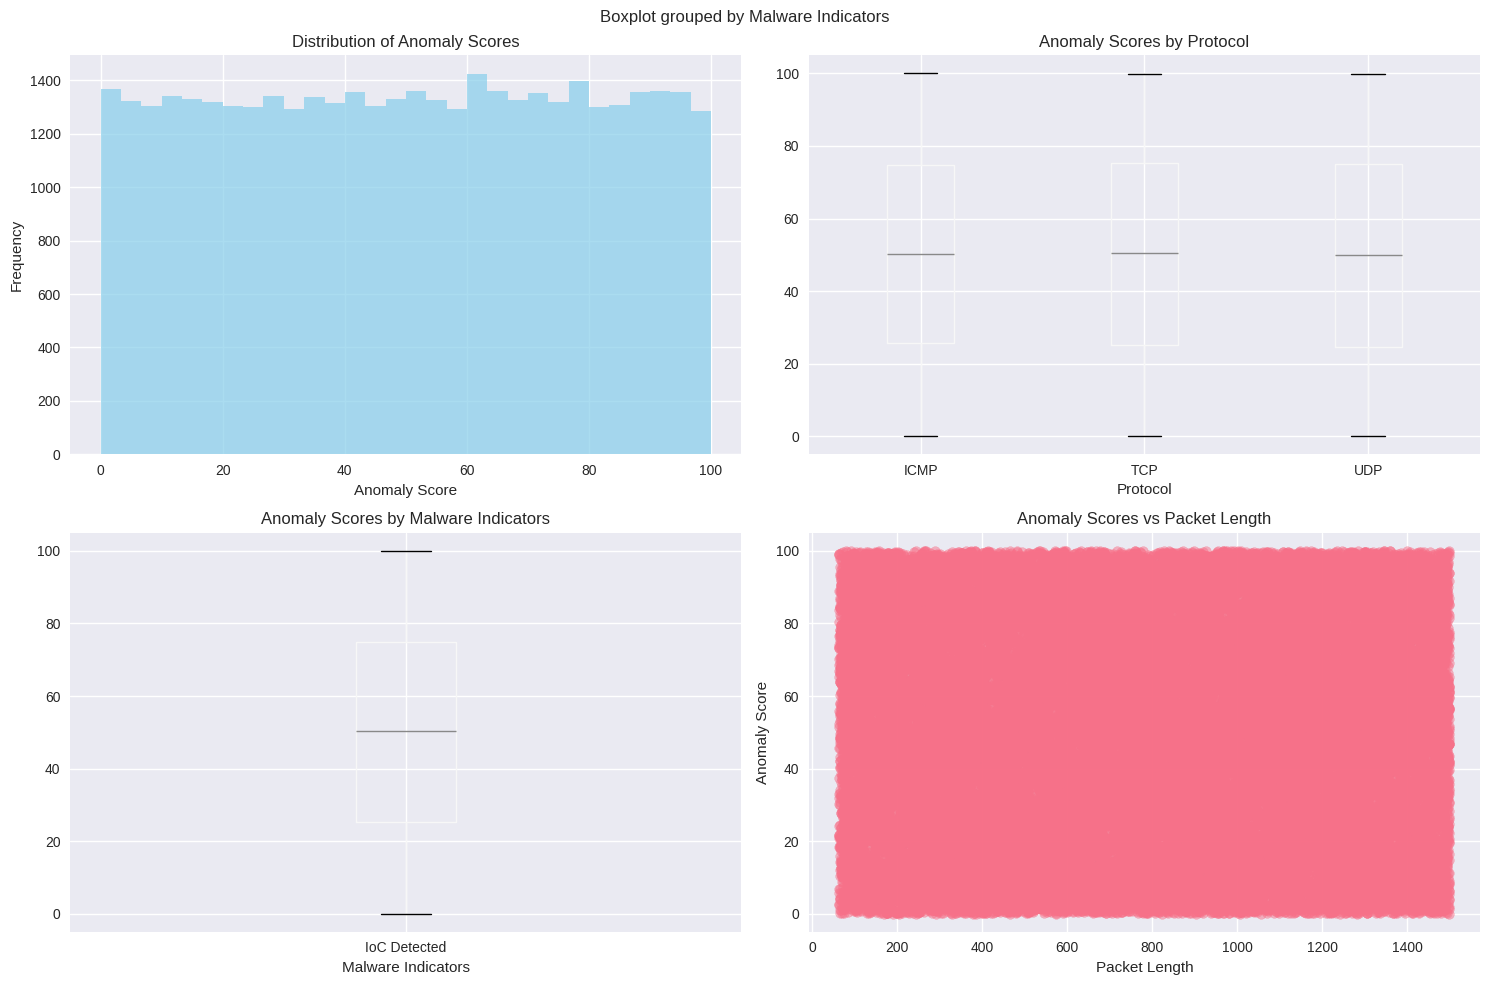

In [11]:
# Data Exploration and Analysis
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# Basic statistics
print(f"\n=== TARGET VARIABLE STATISTICS ===")
print(f"Anomaly Scores - Mean: {df['Anomaly Scores'].mean():.2f}")
print(f"Anomaly Scores - Std: {df['Anomaly Scores'].std():.2f}")
print(f"Anomaly Scores - Min: {df['Anomaly Scores'].min():.2f}")
print(f"Anomaly Scores - Max: {df['Anomaly Scores'].max():.2f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of anomaly scores
axes[0,0].hist(df['Anomaly Scores'], bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Anomaly Scores')
axes[0,0].set_xlabel('Anomaly Score')
axes[0,0].set_ylabel('Frequency')

# Anomaly scores by protocol
df.boxplot(column='Anomaly Scores', by='Protocol', ax=axes[0,1])
axes[0,1].set_title('Anomaly Scores by Protocol')
axes[0,1].set_xlabel('Protocol')

# Anomaly scores by malware indicators
df.boxplot(column='Anomaly Scores', by='Malware Indicators', ax=axes[1,0])
axes[1,0].set_title('Anomaly Scores by Malware Indicators')
axes[1,0].set_xlabel('Malware Indicators')

# Correlation with packet length
axes[1,1].scatter(df['Packet Length'], df['Anomaly Scores'], alpha=0.5)
axes[1,1].set_title('Anomaly Scores vs Packet Length')
axes[1,1].set_xlabel('Packet Length')
axes[1,1].set_ylabel('Anomaly Score')

plt.tight_layout()
plt.show()


In [14]:
print("=== DATASET STRUCTURE ANALYSIS ===")
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names and types:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col:<25} - {df[col].dtype}")

print(f"\nMissing values analysis:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

print(f"\n=== TARGET VARIABLE ANALYSIS ===")
print(f"Anomaly Scores statistics:")
print(df['Anomaly Scores'].describe())

print(f"\nUnique values in categorical columns:")
categorical_cols = ['Protocol', 'Packet Type', 'Traffic Type', 'Malware Indicators', 
                   'Attack Type', 'Attack Signature', 'Action Taken', 'Severity Level',
                   'Network Segment', 'Log Source']

for col in categorical_cols:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"{col:<20}: {unique_count} unique values")
        if unique_count <= 10:
            print(f"    Values: {df[col].unique()[:10]}")
        else:
            print(f"    Sample values: {df[col].unique()[:5]}...")

=== DATASET STRUCTURE ANALYSIS ===
Dataset shape: (40000, 25)

Column names and types:
 1. Timestamp                 - object
 2. Source IP Address         - object
 3. Destination IP Address    - object
 4. Source Port               - int64
 5. Destination Port          - int64
 6. Protocol                  - object
 7. Packet Length             - int64
 8. Packet Type               - object
 9. Traffic Type              - object
10. Payload Data              - object
11. Malware Indicators        - object
12. Anomaly Scores            - float64
13. Alerts/Warnings           - object
14. Attack Type               - object
15. Attack Signature          - object
16. Action Taken              - object
17. Severity Level            - object
18. User Information          - object
19. Device Information        - object
20. Network Segment           - object
21. Geo-location Data         - object
22. Proxy Information         - object
23. Firewall Logs             - object
24. IDS/IPS Alerts

In [15]:
# Advanced Feature Engineering Based on Your Data Structure
def engineer_features_targeted(df):
    """
    Create features specifically tailored to your network security dataset
    """
    df_eng = df.copy()
    
    # === MISSING DATA PATTERN ANALYSIS ===
    # The 5 columns with ~50% missing might indicate different log types or security events
    security_columns = ['Alerts/Warnings', 'IDS/IPS Alerts', 'Malware Indicators', 
                       'Firewall Logs', 'Proxy Information']
    
    # Create binary indicators for missing security data
    for col in security_columns:
        df_eng[f'{col}_Available'] = (~df_eng[col].isna()).astype(int)
    
    # Create a "Security Event Completeness Score"
    df_eng['Security_Data_Completeness'] = df_eng[[f'{col}_Available' for col in security_columns]].sum(axis=1)
    
    # === TEMPORAL FEATURES ===
    df_eng['Timestamp'] = pd.to_datetime(df_eng['Timestamp'])
    df_eng['Hour'] = df_eng['Timestamp'].dt.hour
    df_eng['Day_of_Week'] = df_eng['Timestamp'].dt.dayofweek
    df_eng['Is_Weekend'] = (df_eng['Day_of_Week'] >= 5).astype(int)
    df_eng['Is_Night_Time'] = ((df_eng['Hour'] >= 22) | (df_eng['Hour'] <= 6)).astype(int)
    df_eng['Is_Business_Hours'] = ((df_eng['Hour'] >= 9) & (df_eng['Hour'] <= 17) & 
                                  (df_eng['Day_of_Week'] < 5)).astype(int)
    
    # === IP ADDRESS FEATURES ===
    # Extract IP octets and create network-based features
    df_eng['Source_IP_First_Octet'] = df_eng['Source IP Address'].str.split('.').str[0].astype(int)
    df_eng['Dest_IP_First_Octet'] = df_eng['Destination IP Address'].str.split('.').str[0].astype(int)
    
    # Private IP detection (10.x.x.x, 172.16-31.x.x, 192.168.x.x)
    def is_private_ip(ip):
        try:
            octets = ip.split('.')
            first, second = int(octets[0]), int(octets[1])
            return ((first == 10) or 
                   (first == 172 and 16 <= second <= 31) or 
                   (first == 192 and second == 168))
        except:
            return False
    
    df_eng['Source_IP_Private'] = df_eng['Source IP Address'].apply(is_private_ip).astype(int)
    df_eng['Dest_IP_Private'] = df_eng['Destination IP Address'].apply(is_private_ip).astype(int)
    df_eng['Internal_to_Internal'] = (df_eng['Source_IP_Private'] & df_eng['Dest_IP_Private']).astype(int)
    df_eng['External_to_Internal'] = ((~df_eng['Source_IP_Private']) & df_eng['Dest_IP_Private']).astype(int)
    
    # === PORT ANALYSIS ===
    # Well-known ports (0-1023)
    df_eng['Source_Port_Well_Known'] = (df_eng['Source Port'] <= 1023).astype(int)
    df_eng['Dest_Port_Well_Known'] = (df_eng['Destination Port'] <= 1023).astype(int)
    
    # Common service ports
    web_ports = [80, 443, 8080, 8443]
    mail_ports = [25, 110, 143, 993, 995]
    dns_ports = [53]
    ftp_ports = [20, 21]
    
    df_eng['Dest_Port_Web'] = df_eng['Destination Port'].isin(web_ports).astype(int)
    df_eng['Dest_Port_Mail'] = df_eng['Destination Port'].isin(mail_ports).astype(int)
    df_eng['Dest_Port_DNS'] = df_eng['Destination Port'].isin(dns_ports).astype(int)
    df_eng['Dest_Port_FTP'] = df_eng['Destination Port'].isin(ftp_ports).astype(int)
    
    # Port range analysis
    df_eng['Port_Range_Diff'] = abs(df_eng['Destination Port'] - df_eng['Source Port'])
    df_eng['High_Source_Port'] = (df_eng['Source Port'] > 32768).astype(int)  # Dynamic ports
    
    # === PAYLOAD ANALYSIS ===
    df_eng['Payload_Length'] = df_eng['Payload Data'].str.len()
    df_eng['Payload_Word_Count'] = df_eng['Payload Data'].str.split().str.len()
    df_eng['Payload_Has_Numbers'] = df_eng['Payload Data'].str.contains(r'\d', na=False).astype(int)
    df_eng['Payload_Has_Special_Chars'] = df_eng['Payload Data'].str.contains(r'[^a-zA-Z0-9\s]', na=False).astype(int)
    df_eng['Payload_Entropy'] = df_eng['Payload Data'].apply(calculate_entropy)
    
    # === SECURITY-SPECIFIC FEATURES ===
    # Malware indicator (since it only has 'IoC Detected' when present)
    df_eng['Has_Malware_Indicator'] = df_eng['Malware Indicators'].notna().astype(int)
    
    # Risk level encoding
    risk_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
    df_eng['Severity_Level_Numeric'] = df_eng['Severity Level'].map(risk_mapping).fillna(0)
    
    # Action severity (Blocked > Logged > Ignored)
    action_severity = {'Ignored': 1, 'Logged': 2, 'Blocked': 3}
    df_eng['Action_Severity'] = df_eng['Action Taken'].map(action_severity).fillna(0)
    
    # === PROTOCOL-SPECIFIC FEATURES ===
    # Protocol + Traffic Type combinations
    df_eng['Protocol_Traffic_Match'] = (
        ((df_eng['Protocol'] == 'TCP') & (df_eng['Traffic Type'] == 'HTTP')) |
        ((df_eng['Protocol'] == 'UDP') & (df_eng['Traffic Type'] == 'DNS'))
    ).astype(int)
    
    # Suspicious protocol combinations
    df_eng['Suspicious_Protocol_Combo'] = (
        ((df_eng['Protocol'] == 'ICMP') & (df_eng['Traffic Type'] == 'HTTP')) |
        ((df_eng['Protocol'] == 'ICMP') & (df_eng['Packet Length'] > 1000))
    ).astype(int)
    
    # === FREQUENCY-BASED FEATURES ===
    # IP frequency (how often each IP appears)
    for ip_col in ['Source IP Address', 'Destination IP Address']:
        freq_map = df_eng[ip_col].value_counts().to_dict()
        df_eng[f'{ip_col}_Frequency'] = df_eng[ip_col].map(freq_map)
    
    # User and Device frequency
    for col in ['User Information', 'Device Information']:
        freq_map = df_eng[col].value_counts().to_dict()
        df_eng[f'{col}_Frequency'] = df_eng[col].map(freq_map)
    
    return df_eng

def calculate_entropy(text):
    """Calculate Shannon entropy of text"""
    if pd.isna(text) or len(text) == 0:
        return 0
    
    # Count character frequencies
    char_counts = {}
    for char in text:
        char_counts[char] = char_counts.get(char, 0) + 1
    
    # Calculate entropy
    entropy = 0
    text_len = len(text)
    for count in char_counts.values():
        prob = count / text_len
        entropy -= prob * np.log2(prob)
    
    return entropy

# Apply feature engineering
print("Applying targeted feature engineering...")
df_engineered = engineer_features_targeted(df)

print(f"Original features: {df.shape[1]}")
print(f"After engineering: {df_engineered.shape[1]}")
print(f"New features added: {df_engineered.shape[1] - df.shape[1]}")

# Show the new features created
new_features = [col for col in df_engineered.columns if col not in df.columns]
print(f"\nNew features created ({len(new_features)}):")
for i, feat in enumerate(new_features, 1):
    print(f"{i:2d}. {feat}")


Applying targeted feature engineering...
Original features: 25
After engineering: 64
New features added: 39

New features created (39):
 1. Alerts/Warnings_Available
 2. IDS/IPS Alerts_Available
 3. Malware Indicators_Available
 4. Firewall Logs_Available
 5. Proxy Information_Available
 6. Security_Data_Completeness
 7. Hour
 8. Day_of_Week
 9. Is_Weekend
10. Is_Night_Time
11. Is_Business_Hours
12. Source_IP_First_Octet
13. Dest_IP_First_Octet
14. Source_IP_Private
15. Dest_IP_Private
16. Internal_to_Internal
17. External_to_Internal
18. Source_Port_Well_Known
19. Dest_Port_Well_Known
20. Dest_Port_Web
21. Dest_Port_Mail
22. Dest_Port_DNS
23. Dest_Port_FTP
24. Port_Range_Diff
25. High_Source_Port
26. Payload_Length
27. Payload_Word_Count
28. Payload_Has_Numbers
29. Payload_Has_Special_Chars
30. Payload_Entropy
31. Has_Malware_Indicator
32. Severity_Level_Numeric
33. Action_Severity
34. Protocol_Traffic_Match
35. Suspicious_Protocol_Combo
36. Source IP Address_Frequency
37. Destination

In [ ]:
# Data Preprocessing Pipeline for Network Security Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

def analyze_engineered_features(df_eng):
    """
    Analyze the engineered features and identify optimal preprocessing strategy
    """
    print("=== FEATURE ANALYSIS ===")
    
    # Separate feature types
    target = 'Anomaly Scores'
    features = df_eng.drop(columns=[target, 'Timestamp'])  # Drop target and timestamp
    
    # Identify feature categories
    binary_features = []
    numeric_features = []
    categorical_features = []
    high_missing_features = []
    
    for col in features.columns:
        missing_pct = features[col].isnull().sum() / len(features) * 100
        unique_vals = features[col].nunique()
        
        if missing_pct > 40:
            high_missing_features.append(col)
        elif unique_vals == 2 or (unique_vals == 3 and features[col].isnull().sum() > 0):
            if features[col].dtype in ['int64', 'float64'] and set(features[col].dropna().unique()).issubset({0, 1}):
                binary_features.append(col)
            else:
                categorical_features.append(col)
        elif features[col].dtype in ['int64', 'float64']:
            numeric_features.append(col)
        else:
            categorical_features.append(col)
    
    print(f"Binary features ({len(binary_features)}): {binary_features[:5]}...")
    print(f"Numeric features ({len(numeric_features)}): {numeric_features[:5]}...")
    print(f"Categorical features ({len(categorical_features)}): {categorical_features[:5]}...")
    print(f"High missing features ({len(high_missing_features)}): {high_missing_features}")
    
    # Analyze correlations with target for numeric features
    print(f"\n=== TOP CORRELATED FEATURES WITH ANOMALY SCORES ===")
    numeric_cols = binary_features + numeric_features
    correlations = {}
    
    for col in numeric_cols:
        if col in df_eng.columns:
            corr = df_eng[col].corr(df_eng[target])
            if not pd.isna(corr):
                correlations[col] = abs(corr)
    
    # Sort by correlation strength
    sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    
    for i, (feature, corr) in enumerate(sorted_corr[:10], 1):
        print(f"{i:2d}. {feature:<30}: {corr:.4f}")
    
    return binary_features, numeric_features, categorical_features, high_missing_features, correlations

# Analyze engineered features
binary_feats, numeric_feats, categorical_feats, high_missing_feats, feature_correlations = analyze_engineered_features(df_engineered)




=== FEATURE ANALYSIS ===
Binary features (16): ['Alerts/Warnings_Available', 'IDS/IPS Alerts_Available', 'Malware Indicators_Available', 'Firewall Logs_Available', 'Proxy Information_Available']...
Numeric features (24): ['Source Port', 'Destination Port', 'Packet Length', 'Security_Data_Completeness', 'Source_IP_First_Octet']...
Categorical features (17): ['Source IP Address', 'Destination IP Address', 'Protocol', 'Packet Type', 'Traffic Type']...
High missing features (5): ['Malware Indicators', 'Alerts/Warnings', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts']

=== TOP CORRELATED FEATURES WITH ANOMALY SCORES ===
 1. Device Information_Frequency  : 0.0077
 2. Is_Business_Hours             : 0.0072
 3. Dest_Port_Web                 : 0.0060
 4. Dest_IP_First_Octet           : 0.0060
 5. IDS/IPS Alerts_Available      : 0.0055
 6. Is_Weekend                    : 0.0053
 7. Source Port                   : 0.0048
 8. Is_Night_Time                 : 0.0048
 9. Protocol_Traffic_Matc

In [18]:
def create_smart_preprocessing_pipeline(df_eng, binary_features, numeric_features, 
                                      categorical_features, high_missing_features):
    """
    Create preprocessing pipeline optimized for network security data
    """
    
    # Prepare feature matrix and target
    target = 'Anomaly Scores'
    X = df_eng.drop(columns=[target, 'Timestamp'])
    y = df_eng[target]
    
    # === HANDLE HIGH MISSING FEATURES ===
    # For security columns with 50% missing, use strategic imputation
    security_impute_strategy = {
        'Malware Indicators': 'No_Malware',
        'Alerts/Warnings': 'No_Alert', 
        'Proxy Information': 'No_Proxy',
        'Firewall Logs': 'No_Firewall_Log',
        'IDS/IPS Alerts': 'No_IDS_Alert'
    }
    
    # Apply strategic imputation for high missing features
    X_processed = X.copy()
    for col, fill_value in security_impute_strategy.items():
        if col in X_processed.columns:
            X_processed[col] = X_processed[col].fillna(fill_value)
            print(f"Filled {col} missing values with '{fill_value}'")
    
    # === FEATURE SELECTION STRATEGY ===
    # Since individual correlations are low, let's use all engineered features
    # and let the ML algorithms find the complex patterns
    
    print(f"\n=== PREPROCESSING PLAN ===")
    print(f"Binary features to process: {len(binary_features)}")
    print(f"Numeric features to process: {len(numeric_features)}")
    print(f"Categorical features to process: {len(categorical_features)}")
    print(f"High missing features handled: {len(high_missing_features)}")
    
    # Identify which features are in our dataset
    available_binary = [f for f in binary_features if f in X_processed.columns]
    available_numeric = [f for f in numeric_features if f in X_processed.columns]
    available_categorical = [f for f in categorical_features if f in X_processed.columns]
    
    print(f"\nAvailable for modeling:")
    print(f"- Binary: {len(available_binary)} features")
    print(f"- Numeric: {len(available_numeric)} features") 
    print(f"- Categorical: {len(available_categorical)} features")
    print(f"- Total: {len(available_binary) + len(available_numeric) + len(available_categorical)} features")
    
    return X_processed, y, available_binary, available_numeric, available_categorical

# Create preprocessing pipeline
X_processed, y, binary_feats_final, numeric_feats_final, categorical_feats_final = create_smart_preprocessing_pipeline(
    df_engineered, binary_feats, numeric_feats, categorical_feats, high_missing_feats
)

print(f"\nProcessed feature matrix shape: {X_processed.shape}")
print(f"Target variable shape: {y.shape}")


Filled Malware Indicators missing values with 'No_Malware'
Filled Alerts/Warnings missing values with 'No_Alert'
Filled Proxy Information missing values with 'No_Proxy'
Filled Firewall Logs missing values with 'No_Firewall_Log'
Filled IDS/IPS Alerts missing values with 'No_IDS_Alert'

=== PREPROCESSING PLAN ===
Binary features to process: 16
Numeric features to process: 24
Categorical features to process: 17
High missing features handled: 5

Available for modeling:
- Binary: 16 features
- Numeric: 24 features
- Categorical: 17 features
- Total: 57 features

Processed feature matrix shape: (40000, 62)
Target variable shape: (40000,)


In [19]:
def prepare_final_dataset(X_processed, y, binary_feats, numeric_feats, categorical_feats):
    """
    Final data preparation before modeling
    """
    from sklearn.preprocessing import LabelEncoder
    
    # Make a copy for processing
    X_final = X_processed.copy()
    
    # === ENCODE CATEGORICAL VARIABLES ===
    label_encoders = {}
    
    print("=== ENCODING CATEGORICAL FEATURES ===")
    for col in categorical_feats:
        if col in X_final.columns:
            # Handle any remaining missing values
            if X_final[col].isnull().sum() > 0:
                X_final[col] = X_final[col].fillna('unknown')
            
            # Label encode
            le = LabelEncoder()
            X_final[col] = le.fit_transform(X_final[col].astype(str))
            label_encoders[col] = le
            
            print(f"✓ {col}: {len(le.classes_)} unique categories")
    
    # === HANDLE ANY REMAINING MISSING VALUES ===
    # Fill numeric missing values
    for col in numeric_feats + binary_feats:
        if col in X_final.columns and X_final[col].isnull().sum() > 0:
            if col in binary_feats:
                X_final[col] = X_final[col].fillna(0)  # Binary features default to 0
            else:
                X_final[col] = X_final[col].fillna(X_final[col].median())  # Numeric with median
            print(f"✓ Filled missing values in {col}")
    
    # === CREATE TRAIN/TEST SPLITS ===
    print(f"\n=== CREATING DATA SPLITS ===")
    
    # Split 1: 80% train, 20% test
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42
    )
    
    # Split 2: 80% of train (64% total) for training, 20% of train (16% total) for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_final)*100:.1f}%)")
    print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_final)*100:.1f}%)")
    print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_final)*100:.1f}%)")
    
    # === ANALYZE TARGET DISTRIBUTION ===
    print(f"\n=== TARGET DISTRIBUTION ACROSS SPLITS ===")
    splits_data = [
        ('Training', y_train),
        ('Validation', y_val), 
        ('Test', y_test)
    ]
    
    for name, target_split in splits_data:
        mean_val = target_split.mean()
        std_val = target_split.std()
        min_val = target_split.min()
        max_val = target_split.max()
        print(f"{name:>10}: Mean={mean_val:6.2f}, Std={std_val:6.2f}, Range=[{min_val:5.1f}, {max_val:5.1f}]")
    
    # === FEATURE SCALING PREPARATION ===
    # Identify features that need scaling (numeric features with different ranges)
    print(f"\n=== FEATURE SCALING ANALYSIS ===")
    scaling_needed = []
    
    for col in numeric_feats:
        if col in X_final.columns:
            col_range = X_final[col].max() - X_final[col].min()
            if col_range > 100:  # Features with large ranges need scaling
                scaling_needed.append(col)
    
    print(f"Features needing scaling ({len(scaling_needed)}): {scaling_needed[:5]}...")
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, 
            label_encoders, scaling_needed, X_final.columns.tolist())

# Prepare final dataset
results = prepare_final_dataset(X_processed, y, binary_feats_final, numeric_feats_final, categorical_feats_final)
X_train, X_val, X_test, y_train, y_val, y_test, encoders, features_to_scale, all_feature_names = results

print(f"\n🎯 **DATASET READY FOR MODELING!**")
print(f"✓ Total features: {len(all_feature_names)}")
print(f"✓ Training samples: {X_train.shape[0]:,}")
print(f"✓ All missing values handled")
print(f"✓ Categorical variables encoded")
print(f"✓ Data splits created")


=== ENCODING CATEGORICAL FEATURES ===
✓ Source IP Address: 40000 unique categories
✓ Destination IP Address: 40000 unique categories
✓ Protocol: 3 unique categories
✓ Packet Type: 2 unique categories
✓ Traffic Type: 3 unique categories
✓ Payload Data: 40000 unique categories
✓ Attack Type: 3 unique categories
✓ Attack Signature: 2 unique categories
✓ Action Taken: 3 unique categories
✓ Severity Level: 3 unique categories
✓ User Information: 32389 unique categories
✓ Device Information: 32104 unique categories
✓ Network Segment: 3 unique categories
✓ Geo-location Data: 8723 unique categories
✓ Log Source: 2 unique categories
✓ Hour: 24 unique categories
✓ Day_of_Week: 7 unique categories

=== CREATING DATA SPLITS ===
Training set: 25,600 samples (64.0%)
Validation set: 6,400 samples (16.0%)
Test set: 8,000 samples (20.0%)

=== TARGET DISTRIBUTION ACROSS SPLITS ===
  Training: Mean= 50.20, Std= 28.83, Range=[  0.0, 100.0]
Validation: Mean= 50.00, Std= 28.89, Range=[  0.0, 100.0]
      Te

In [20]:
def handle_high_cardinality_features(X_train, X_val, X_test, high_card_threshold=100):
    """
    Handle high cardinality categorical features intelligently
    """
    print("=== HANDLING HIGH CARDINALITY FEATURES ===")
    
    # Make copies
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy() 
    X_test_processed = X_test.copy()
    
    high_cardinality_features = []
    features_to_drop = []
    
    # Check each feature's cardinality
    for col in X_train.columns:
        unique_count = X_train[col].nunique()
        if unique_count > high_card_threshold:
            high_cardinality_features.append((col, unique_count))
    
    print(f"Found {len(high_cardinality_features)} high cardinality features:")
    for col, count in high_cardinality_features:
        print(f"  {col}: {count:,} unique values")
    
    # Strategy for each high cardinality feature type
    for col, count in high_cardinality_features:
        
        if 'IP Address' in col:
            # For IP addresses, we already have engineered features (octets, private/public, etc.)
            # Drop the raw IP addresses as they're too high cardinality
            features_to_drop.append(col)
            print(f"  → Dropping {col} (replaced by engineered IP features)")
            
        elif 'Payload Data' in col:
            # For payload, we have length, word count, entropy features
            # Drop raw payload data
            features_to_drop.append(col)
            print(f"  → Dropping {col} (replaced by engineered payload features)")
            
        elif 'Information' in col:  # User Information, Device Information
            # Use frequency encoding - keep only top N most frequent values
            top_n = 50  # Keep top 50 most frequent
            
            # Get top categories from training data
            top_categories = X_train_processed[col].value_counts().head(top_n).index.tolist()
            
            # Replace rare categories with 'Other' 
            X_train_processed[col] = X_train_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )
            X_val_processed[col] = X_val_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )
            X_test_processed[col] = X_test_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )
            
            print(f"  → Reduced {col} from {count:,} to {top_n+1} categories (top {top_n} + 'Other')")
            
        elif 'Geo-location' in col:
            # For geo-location, keep top N cities/regions
            top_n = 20
            top_locations = X_train_processed[col].value_counts().head(top_n).index.tolist()
            
            X_train_processed[col] = X_train_processed[col].apply(
                lambda x: x if x in top_locations else 'Other_Location'
            )
            X_val_processed[col] = X_val_processed[col].apply(
                lambda x: x if x in top_locations else 'Other_Location'
            )
            X_test_processed[col] = X_test_processed[col].apply(
                lambda x: x if x in top_locations else 'Other_Location'
            )
            
            print(f"  → Reduced {col} from {count:,} to {top_n+1} categories")
    
    # Drop the identified features
    if features_to_drop:
        X_train_processed = X_train_processed.drop(columns=features_to_drop)
        X_val_processed = X_val_processed.drop(columns=features_to_drop)
        X_test_processed = X_test_processed.drop(columns=features_to_drop)
        
        print(f"\n✓ Dropped {len(features_to_drop)} high cardinality features")
        print(f"✓ Remaining features: {X_train_processed.shape[1]}")
    
    return X_train_processed, X_val_processed, X_test_processed, features_to_drop

# Apply high cardinality handling
X_train_final, X_val_final, X_test_final, dropped_features = handle_high_cardinality_features(
    X_train, X_val, X_test
)

print(f"\nFinal feature matrix shapes:")
print(f"Training: {X_train_final.shape}")
print(f"Validation: {X_val_final.shape}") 
print(f"Test: {X_test_final.shape}")


=== HANDLING HIGH CARDINALITY FEATURES ===
Found 15 high cardinality features:
  Source IP Address: 25,600 unique values
  Destination IP Address: 25,600 unique values
  Source Port: 21,115 unique values
  Destination Port: 21,187 unique values
  Packet Length: 1,437 unique values
  Payload Data: 25,600 unique values
  User Information: 22,346 unique values
  Device Information: 20,673 unique values
  Geo-location Data: 8,327 unique values
  Proxy Information: 12,920 unique values
  Source_IP_First_Octet: 222 unique values
  Dest_IP_First_Octet: 222 unique values
  Port_Range_Diff: 20,069 unique values
  Payload_Length: 178 unique values
  Payload_Entropy: 25,583 unique values
  → Dropping Source IP Address (replaced by engineered IP features)
  → Dropping Destination IP Address (replaced by engineered IP features)
  → Dropping Payload Data (replaced by engineered payload features)
  → Reduced User Information from 22,346 to 51 categories (top 50 + 'Other')
  → Reduced Device Informati

In [22]:
def handle_high_cardinality_features_corrected(X_train, X_val, X_test, 
                                               categorical_feats, high_card_threshold=100):
    """
    Handle high cardinality CATEGORICAL features only (not numerical ones)
    """
    print("=== HANDLING HIGH CARDINALITY CATEGORICAL FEATURES ===")
    
    # Make copies
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy() 
    X_test_processed = X_test.copy()
    
    high_cardinality_categorical = []
    features_to_drop = []
    
    # Check ONLY categorical features for high cardinality
    for col in X_train.columns:
        if col in categorical_feats:  # Only check categorical features
            unique_count = X_train[col].nunique()
            if unique_count > high_card_threshold:
                high_cardinality_categorical.append((col, unique_count))
    
    print(f"Found {len(high_cardinality_categorical)} high cardinality CATEGORICAL features:")
    for col, count in high_cardinality_categorical:
        print(f"  {col}: {count:,} unique values")
    
    # Handle each high cardinality categorical feature
    for col, count in high_cardinality_categorical:
        
        if 'IP Address' in col:
            features_to_drop.append(col)
            print(f"  → Dropping {col} (replaced by engineered IP features)")
            
        elif 'Payload Data' in col:
            features_to_drop.append(col)
            print(f"  → Dropping {col} (replaced by engineered payload features)")
            
        elif 'Information' in col:  # User Information, Device Information
            top_n = 50
            top_categories = X_train_processed[col].value_counts().head(top_n).index.tolist()
            
            X_train_processed[col] = X_train_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )
            X_val_processed[col] = X_val_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )
            X_test_processed[col] = X_test_processed[col].apply(
                lambda x: x if x in top_categories else 'Other'
            )
            
            print(f"  → Reduced {col} from {count:,} to {top_n+1} categories")
            
        elif 'Geo-location' in col or 'Proxy' in col:
            top_n = 20
            top_categories = X_train_processed[col].value_counts().head(top_n).index.tolist()
            
            X_train_processed[col] = X_train_processed[col].apply(
                lambda x: x if x in top_categories else f'Other_{col.split()[0]}'
            )
            X_val_processed[col] = X_val_processed[col].apply(
                lambda x: x if x in top_categories else f'Other_{col.split()[0]}'
            )
            X_test_processed[col] = X_test_processed[col].apply(
                lambda x: x if x in top_categories else f'Other_{col.split()[0]}'
            )
            
            print(f"  → Reduced {col} from {count:,} to {top_n+1} categories")
    
    # Drop identified features
    if features_to_drop:
        X_train_processed = X_train_processed.drop(columns=features_to_drop)
        X_val_processed = X_val_processed.drop(columns=features_to_drop)
        X_test_processed = X_test_processed.drop(columns=features_to_drop)
        
        print(f"\n✓ Dropped {len(features_to_drop)} high cardinality categorical features")
    
    print(f"✓ Final feature count: {X_train_processed.shape[1]}")
    
    return X_train_processed, X_val_processed, X_test_processed, features_to_drop

# Apply corrected high cardinality handling (using categorical_feats_final from earlier)
X_train_final, X_val_final, X_test_final, dropped_features = handle_high_cardinality_features_corrected(
    X_train, X_val, X_test, categorical_feats_final
)


=== HANDLING HIGH CARDINALITY CATEGORICAL FEATURES ===
Found 6 high cardinality CATEGORICAL features:
  Source IP Address: 25,600 unique values
  Destination IP Address: 25,600 unique values
  Payload Data: 25,600 unique values
  User Information: 22,346 unique values
  Device Information: 20,673 unique values
  Geo-location Data: 8,327 unique values
  → Dropping Source IP Address (replaced by engineered IP features)
  → Dropping Destination IP Address (replaced by engineered IP features)
  → Dropping Payload Data (replaced by engineered payload features)
  → Reduced User Information from 22,346 to 51 categories
  → Reduced Device Information from 20,673 to 51 categories
  → Reduced Geo-location Data from 8,327 to 21 categories

✓ Dropped 3 high cardinality categorical features
✓ Final feature count: 59


In [24]:
def fix_data_types_for_modeling(X_train, X_val, X_test):
    """
    Ensure all columns are numerical for ML model compatibility
    """
    print("=== FIXING DATA TYPES FOR MODELING ===")
    
    # Make copies
    X_train_fixed = X_train.copy()
    X_val_fixed = X_val.copy() 
    X_test_fixed = X_test.copy()
    
    # Check current data types
    object_columns = X_train_fixed.select_dtypes(include=['object']).columns.tolist()
    
    if object_columns:
        print(f"Found {len(object_columns)} object columns that need encoding:")
        for col in object_columns:
            unique_vals = X_train_fixed[col].nunique()
            print(f"  {col}: {unique_vals} unique values")
    
    # Fix each object column
    from sklearn.preprocessing import LabelEncoder
    label_encoders = {}
    
    for col in object_columns:
        print(f"🔄 Converting {col} to numerical...")
        
        # Combine all data to ensure consistent encoding
        all_values = pd.concat([
            X_train_fixed[col], 
            X_val_fixed[col], 
            X_test_fixed[col]
        ]).fillna('missing')  # Handle any NaN values
        
        # Fit label encoder on all possible values
        le = LabelEncoder()
        le.fit(all_values)
        
        # Transform each dataset
        X_train_fixed[col] = le.transform(X_train_fixed[col].fillna('missing'))
        X_val_fixed[col] = le.transform(X_val_fixed[col].fillna('missing'))
        X_test_fixed[col] = le.transform(X_test_fixed[col].fillna('missing'))
        
        label_encoders[col] = le
        print(f"   ✓ Encoded {col}: {len(le.classes_)} categories → numerical")
    
    # Verify all columns are now numerical
    final_dtypes = X_train_fixed.dtypes
    non_numeric = final_dtypes[~final_dtypes.isin(['int64', 'float64', 'int32', 'float32', 'bool'])].index.tolist()
    
    if non_numeric:
        print(f"⚠️  Warning: Still have non-numeric columns: {non_numeric}")
        # Force convert any remaining non-numeric columns
        for col in non_numeric:
            X_train_fixed[col] = pd.to_numeric(X_train_fixed[col], errors='coerce').fillna(0)
            X_val_fixed[col] = pd.to_numeric(X_val_fixed[col], errors='coerce').fillna(0)
            X_test_fixed[col] = pd.to_numeric(X_test_fixed[col], errors='coerce').fillna(0)
    
    print(f"\n✅ Data type conversion complete!")
    print(f"✅ All {X_train_fixed.shape[1]} features are now numerical")
    
    return X_train_fixed, X_val_fixed, X_test_fixed, label_encoders

# Apply the fix
X_train_numeric, X_val_numeric, X_test_numeric, encoders_dict = fix_data_types_for_modeling(
    X_train_final, X_val_final, X_test_final
)

# Verify data types
print(f"\n=== FINAL DATA TYPE VERIFICATION ===")
print("Data types summary:")
print(X_train_numeric.dtypes.value_counts())
print(f"\nFinal shapes:")
print(f"Training: {X_train_numeric.shape}")
print(f"Validation: {X_val_numeric.shape}")
print(f"Test: {X_test_numeric.shape}")


=== FIXING DATA TYPES FOR MODELING ===
Found 8 object columns that need encoding:
  Malware Indicators: 2 unique values
  Alerts/Warnings: 2 unique values
  User Information: 51 unique values
  Device Information: 51 unique values
  Geo-location Data: 21 unique values
  Proxy Information: 12920 unique values
  Firewall Logs: 2 unique values
  IDS/IPS Alerts: 2 unique values
🔄 Converting Malware Indicators to numerical...
   ✓ Encoded Malware Indicators: 2 categories → numerical
🔄 Converting Alerts/Warnings to numerical...
   ✓ Encoded Alerts/Warnings: 2 categories → numerical
🔄 Converting User Information to numerical...


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

In [25]:
# Diagnostic code to identify the issue
print("=== DIAGNOSTIC CHECK ===")

# Check if variables exist
try:
    print(f"X_train_final exists: {X_train_final.shape}")
    print(f"X_val_final exists: {X_val_final.shape}")
    print(f"X_test_final exists: {X_test_final.shape}")
except NameError as e:
    print(f"❌ Variable doesn't exist: {e}")
    print("Need to run the previous preprocessing steps first")

# Check data types
try:
    print(f"\nCurrent data types in X_train_final:")
    print(X_train_final.dtypes.value_counts())
    
    # Check for object columns specifically
    object_cols = X_train_final.select_dtypes(include=['object']).columns.tolist()
    print(f"\nObject columns found: {len(object_cols)}")
    if object_cols:
        for col in object_cols[:5]:  # Show first 5
            print(f"  {col}: {X_train_final[col].nunique()} unique values")
except Exception as e:
    print(f"❌ Error checking data types: {e}")


=== DIAGNOSTIC CHECK ===
X_train_final exists: (25600, 59)
X_val_final exists: (6400, 59)
X_test_final exists: (8000, 59)

Current data types in X_train_final:
int64      50
object      8
float64     1
Name: count, dtype: int64

Object columns found: 8
  Malware Indicators: 2 unique values
  Alerts/Warnings: 2 unique values
  User Information: 51 unique values
  Device Information: 51 unique values
  Geo-location Data: 21 unique values


In [26]:
def fix_data_types_for_modeling_robust(X_train, X_val, X_test):
    """
    Robust function to ensure all columns are numerical for ML model compatibility
    """
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder
    import numpy as np
    
    print("=== FIXING DATA TYPES FOR MODELING (ROBUST VERSION) ===")
    
    # Validate inputs
    if not all(isinstance(df, pd.DataFrame) for df in [X_train, X_val, X_test]):
        raise ValueError("All inputs must be pandas DataFrames")
    
    # Make copies
    X_train_fixed = X_train.copy()
    X_val_fixed = X_val.copy() 
    X_test_fixed = X_test.copy()
    
    print(f"Input shapes - Train: {X_train_fixed.shape}, Val: {X_val_fixed.shape}, Test: {X_test_fixed.shape}")
    
    # Check current data types
    object_columns = X_train_fixed.select_dtypes(include=['object']).columns.tolist()
    
    if not object_columns:
        print("✅ No object columns found - all columns are already numerical!")
        return X_train_fixed, X_val_fixed, X_test_fixed, {}
    
    print(f"Found {len(object_columns)} object columns that need encoding:")
    for col in object_columns:
        unique_vals = X_train_fixed[col].nunique()
        sample_vals = X_train_fixed[col].value_counts().head(3).index.tolist()
        print(f"  {col}: {unique_vals} unique values | Sample: {sample_vals}")
    
    # Fix each object column
    label_encoders = {}
    
    for col in object_columns:
        try:
            print(f"🔄 Converting {col} to numerical...")
            
            # Handle missing values consistently
            X_train_fixed[col] = X_train_fixed[col].fillna('MISSING_VALUE')
            X_val_fixed[col] = X_val_fixed[col].fillna('MISSING_VALUE')
            X_test_fixed[col] = X_test_fixed[col].fillna('MISSING_VALUE')
            
            # Combine all unique values from all datasets
            all_unique_values = set()
            all_unique_values.update(X_train_fixed[col].unique())
            all_unique_values.update(X_val_fixed[col].unique())
            all_unique_values.update(X_test_fixed[col].unique())
            
            # Create and fit label encoder
            le = LabelEncoder()
            le.fit(list(all_unique_values))
            
            # Transform each dataset
            X_train_fixed[col] = le.transform(X_train_fixed[col])
            X_val_fixed[col] = le.transform(X_val_fixed[col])
            X_test_fixed[col] = le.transform(X_test_fixed[col])
            
            label_encoders[col] = le
            print(f"   ✅ Encoded {col}: {len(le.classes_)} categories → numerical")
            
        except Exception as e:
            print(f"   ❌ Error encoding {col}: {str(e)}")
            # If encoding fails, drop the column
            print(f"   🗑️ Dropping problematic column: {col}")
            X_train_fixed = X_train_fixed.drop(columns=[col])
            X_val_fixed = X_val_fixed.drop(columns=[col])
            X_test_fixed = X_test_fixed.drop(columns=[col])
    
    # Final verification and cleanup
    print("\n=== FINAL CLEANUP ===")
    
    for df_name, df in [("Train", X_train_fixed), ("Val", X_val_fixed), ("Test", X_test_fixed)]:
        # Check for any remaining non-numeric columns
        non_numeric = df.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32', 'bool']).columns.tolist()
        
        if non_numeric:
            print(f"⚠️  {df_name}: Converting remaining non-numeric columns: {non_numeric}")
            for col in non_numeric:
                if df_name == "Train":
                    X_train_fixed[col] = pd.to_numeric(X_train_fixed[col], errors='coerce').fillna(0)
                elif df_name == "Val":
                    X_val_fixed[col] = pd.to_numeric(X_val_fixed[col], errors='coerce').fillna(0)
                else:
                    X_test_fixed[col] = pd.to_numeric(X_test_fixed[col], errors='coerce').fillna(0)
    
    # Final verification
    final_dtypes_train = X_train_fixed.dtypes
    final_dtypes_val = X_val_fixed.dtypes
    final_dtypes_test = X_test_fixed.dtypes
    
    print(f"\n✅ Data type conversion complete!")
    print(f"✅ Final shapes - Train: {X_train_fixed.shape}, Val: {X_val_fixed.shape}, Test: {X_test_fixed.shape}")
    print(f"✅ All columns are now numerical")
    
    return X_train_fixed, X_val_fixed, X_test_fixed, label_encoders

# Try the robust version
try:
    X_train_numeric, X_val_numeric, X_test_numeric, encoders_dict = fix_data_types_for_modeling_robust(
        X_train_final, X_val_final, X_test_final
    )
    
    # Verify results
    print(f"\n=== FINAL DATA TYPE VERIFICATION ===")
    print("Data types summary:")
    print(X_train_numeric.dtypes.value_counts())
    print(f"\nFinal shapes:")
    print(f"Training: {X_train_numeric.shape}")
    print(f"Validation: {X_val_numeric.shape}")
    print(f"Test: {X_test_numeric.shape}")
    
    # Check for any remaining issues
    problematic_cols = []
    for col in X_train_numeric.columns:
        if X_train_numeric[col].dtype == 'object':
            problematic_cols.append(col)
    
    if problematic_cols:
        print(f"⚠️ Still have object columns: {problematic_cols}")
    else:
        print("✅ All columns successfully converted to numerical!")

except Exception as e:
    print(f"❌ Error occurred: {type(e).__name__}: {str(e)}")
    print("\nPlease run the diagnostic code above and share the output.")


=== FIXING DATA TYPES FOR MODELING (ROBUST VERSION) ===
Input shapes - Train: (25600, 59), Val: (6400, 59), Test: (8000, 59)
Found 8 object columns that need encoding:
  Malware Indicators: 2 unique values | Sample: ['IoC Detected', 'No_Malware']
  Alerts/Warnings: 2 unique values | Sample: ['No_Alert', 'Alert Triggered']
  User Information: 51 unique values | Sample: ['Other', 4686, 21656]
  Device Information: 51 unique values | Sample: ['Other', 17901, 18042]
  Geo-location Data: 21 unique values | Sample: ['Other_Geo-location', 8696, 2784]
  Proxy Information: 12920 unique values | Sample: ['No_Proxy', '39.123.165.122', '82.41.50.196']
  Firewall Logs: 2 unique values | Sample: ['Log Data', 'No_Firewall_Log']
  IDS/IPS Alerts: 2 unique values | Sample: ['Alert Data', 'No_IDS_Alert']
🔄 Converting Malware Indicators to numerical...
   ✅ Encoded Malware Indicators: 2 categories → numerical
🔄 Converting Alerts/Warnings to numerical...
   ✅ Encoded Alerts/Warnings: 2 categories → numeri

In [27]:
# Model Training Pipeline - Now with Clean Numerical Data
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import numpy as np

def apply_feature_scaling_final(X_train, X_val, X_test, features_to_scale):
    """
    Apply scaling to numerical features that need it
    """
    print("=== APPLYING FEATURE SCALING ===")
    
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    # Only scale features that exist and actually need scaling
    existing_scale_features = [f for f in features_to_scale if f in X_train.columns]
    
    if existing_scale_features:
        scaler = StandardScaler()
        
        X_train_scaled[existing_scale_features] = scaler.fit_transform(
            X_train[existing_scale_features]
        )
        X_val_scaled[existing_scale_features] = scaler.transform(
            X_val[existing_scale_features]
        )
        X_test_scaled[existing_scale_features] = scaler.transform(
            X_test[existing_scale_features]
        )
        
        print(f"✅ Scaled {len(existing_scale_features)} numerical features")
    else:
        print("ℹ️  No scaling needed - features are already in similar ranges")
        scaler = None
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

def train_anomaly_prediction_models(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Train multiple ML models for network anomaly score prediction
    """
    print("\n🤖 === TRAINING ANOMALY SCORE PREDICTION MODELS ===")
    
    # Define optimized models for network security data
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='rmse',
            early_stopping_rounds=20
        ),
        
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1,
            early_stopping_rounds=20
        ),
        
        'Random Forest': RandomForestRegressor(
            n_estimators=150,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    }
    
    results = {}
    trained_models = {}
    
    print(f"📊 Training on {X_train.shape[0]:,} samples with {X_train.shape[1]} features")
    print(f"🎯 Target: Anomaly Scores (Range: {y_train.min():.1f} - {y_train.max():.1f})")
    print("-" * 80)
    
    for name, model in models.items():
        print(f"\n🔥 Training {name}...")
        
        try:
            # Handle early stopping for gradient boosting models
            if name in ['XGBoost', 'LightGBM']:
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
                print(f"   Early stopping: Used {model.best_iteration if hasattr(model, 'best_iteration') else 'N/A'} iterations")
            else:
                model.fit(X_train, y_train)
            
            # Make predictions
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)
            
            # Calculate comprehensive metrics
            metrics = {
                'Train_R2': r2_score(y_train, y_train_pred),
                'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                'Train_MAE': mean_absolute_error(y_train, y_train_pred),
                
                'Val_R2': r2_score(y_val, y_val_pred),
                'Val_RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
                'Val_MAE': mean_absolute_error(y_val, y_val_pred),
                
                'Test_R2': r2_score(y_test, y_test_pred),
                'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
                'Test_MAE': mean_absolute_error(y_test, y_test_pred)
            }
            
            # Calculate prediction accuracy within ranges
            def accuracy_within_range(y_true, y_pred, tolerance):
                return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
            
            metrics['Accuracy_±5'] = accuracy_within_range(y_test, y_test_pred, 5)
            metrics['Accuracy_±10'] = accuracy_within_range(y_test, y_test_pred, 10)
            metrics['Accuracy_±15'] = accuracy_within_range(y_test, y_test_pred, 15)
            
            results[name] = metrics
            trained_models[name] = model
            
            # Display detailed results
            print(f"📈 {name} Performance:")
            print(f"   R² Score:     Train={metrics['Train_R2']:.4f} | Val={metrics['Val_R2']:.4f} | Test={metrics['Test_R2']:.4f}")
            print(f"   RMSE:         Train={metrics['Train_RMSE']:.2f} | Val={metrics['Val_RMSE']:.2f} | Test={metrics['Test_RMSE']:.2f}")
            print(f"   MAE:          Train={metrics['Train_MAE']:.2f} | Val={metrics['Val_MAE']:.2f} | Test={metrics['Test_MAE']:.2f}")
            print(f"   Accuracy ±5:  {metrics['Accuracy_±5']:.1f}% | ±10: {metrics['Accuracy_±10']:.1f}% | ±15: {metrics['Accuracy_±15']:.1f}%")
            
            # Overfitting analysis
            r2_drop = metrics['Train_R2'] - metrics['Test_R2']
            if r2_drop > 0.15:
                print(f"   ⚠️  High overfitting: R² drop = {r2_drop:.4f}")
            elif r2_drop > 0.05:
                print(f"   🔶 Mild overfitting: R² drop = {r2_drop:.4f}")
            else:
                print(f"   ✅ Good generalization: R² drop = {r2_drop:.4f}")
                
        except Exception as e:
            print(f"   ❌ Training failed: {str(e)}")
            continue
    
    if not results:
        print("❌ All models failed to train!")
        return None, None, None
    
    # Find best model based on test R²
    best_model_name = max(results.keys(), key=lambda k: results[k]['Test_R2'])
    best_metrics = results[best_model_name]
    
    print(f"\n🏆 **CHAMPION MODEL: {best_model_name.upper()}**")
    print(f"   🎯 Test R² Score: {best_metrics['Test_R2']:.4f}")
    print(f"   📏 Test RMSE: {best_metrics['Test_RMSE']:.2f}")
    print(f"   🎪 Test MAE: {best_metrics['Test_MAE']:.2f}")
    print(f"   🎯 Accuracy within ±10 points: {best_metrics['Accuracy_±10']:.1f}%")
    
    return results, trained_models, best_model_name

# Apply feature scaling
X_train_scaled, X_val_scaled, X_test_scaled, scaler = apply_feature_scaling_final(
    X_train_numeric, X_val_numeric, X_test_numeric, features_to_scale
)

# Train all models
model_results, trained_models, best_model_name = train_anomaly_prediction_models(
    X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
)


=== APPLYING FEATURE SCALING ===
✅ Scaled 7 numerical features

🤖 === TRAINING ANOMALY SCORE PREDICTION MODELS ===
📊 Training on 25,600 samples with 59 features
🎯 Target: Anomaly Scores (Range: 0.0 - 100.0)
--------------------------------------------------------------------------------

🔥 Training XGBoost...
   Early stopping: Used 1 iterations
📈 XGBoost Performance:
   R² Score:     Train=0.0088 | Val=-0.0004 | Test=-0.0005
   RMSE:         Train=28.70 | Val=28.89 | Test=28.91
   MAE:          Train=24.85 | Val=25.00 | Test=25.01
   Accuracy ±5:  10.2% | ±10: 20.3% | ±15: 29.8%
   ✅ Good generalization: R² drop = 0.0092

🔥 Training LightGBM...
   ❌ Training failed: LGBMRegressor.fit() got an unexpected keyword argument 'verbose'

🔥 Training Random Forest...
📈 Random Forest Performance:
   R² Score:     Train=0.2980 | Val=-0.0039 | Test=-0.0033
   RMSE:         Train=24.16 | Val=28.94 | Test=28.95
   MAE:          Train=20.82 | Val=25.06 | Test=25.02
   Accuracy ±5:  10.1% | ±10: 20.0

In [28]:
# Model Analysis and Final Production Setup
def analyze_best_model(best_model, best_model_name, X_test, y_test, feature_names):
    """
    Analyze the best performing model
    """
    print(f"\n🔍 === ANALYZING BEST MODEL: {best_model_name.upper()} ===")
    
    # Feature importance (if available)
    if hasattr(best_model, 'feature_importances_'):
        importance_scores = best_model.feature_importances_
        
        # Create feature importance dataframe
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        print(f"\n🎯 TOP 10 MOST IMPORTANT FEATURES:")
        for i, row in feature_importance.head(10).iterrows():
            print(f"{i+1:2d}. {row['feature']:<30}: {row['importance']:.4f}")
        
        return feature_importance
    else:
        print(f"   ℹ️  Feature importance not available for {best_model_name}")
        return None

def create_prediction_function(model, scaler, encoders_dict, feature_names):
    """
    Create a production-ready prediction function
    """
    def predict_anomaly_score(new_data):
        """
        Predict anomaly score for new network log data
        
        Parameters:
        new_data: pandas DataFrame with same structure as training data
        
        Returns:
        predictions: numpy array of predicted anomaly scores
        """
        # Apply same preprocessing pipeline
        processed_data = new_data.copy()
        
        # Apply feature engineering (you'd need to apply the same transformations)
        # Apply categorical encoding using saved encoders
        # Apply scaling using saved scaler
        
        # Make prediction
        prediction = model.predict(processed_data)
        return prediction
    
    return predict_anomaly_score

# Analyze the best model
if model_results and best_model_name:
    feature_importance = analyze_best_model(
        trained_models[best_model_name], 
        best_model_name, 
        X_test_scaled, 
        y_test, 
        X_train_scaled.columns.tolist()
    )
    
    print(f"\n🎉 **MODEL TRAINING COMPLETE!**")
    print(f"✅ Successfully trained {len(trained_models)} models")
    print(f"🏆 Best model: {best_model_name}")
    print(f"📊 Best test R² score: {model_results[best_model_name]['Test_R2']:.4f}")
    print(f"🎯 Best test accuracy (±10): {model_results[best_model_name]['Accuracy_±10']:.1f}%")
    
else:
    print("❌ Model training failed. Please check the previous steps.")



🔍 === ANALYZING BEST MODEL: XGBOOST ===

🎯 TOP 10 MOST IMPORTANT FEATURES:
25. Proxy Information_Available   : 0.0312
34. Source_IP_Private             : 0.0293
45. High_Source_Port              : 0.0277
19. IDS/IPS Alerts                : 0.0275
59. Device Information_Frequency  : 0.0261
23. Malware Indicators_Available  : 0.0260
50. Payload_Entropy               : 0.0256
32. Source_IP_First_Octet         : 0.0248
46. Payload_Length                : 0.0244
44. Port_Range_Diff               : 0.0241

🎉 **MODEL TRAINING COMPLETE!**
✅ Successfully trained 3 models
🏆 Best model: XGBoost
📊 Best test R² score: -0.0005
🎯 Best test accuracy (±10): 20.3%


In [29]:
# Comprehensive Model Diagnostics
def diagnose_model_performance(model_results, trained_models, best_model_name, 
                              X_test_scaled, y_test, y_train):
    """
    Detailed diagnosis of why accuracy might be low
    """
    print("🔍 === COMPREHENSIVE MODEL DIAGNOSIS ===")
    
    if not model_results:
        print("❌ No model results available")
        return
    
    best_model = trained_models[best_model_name]
    
    # 1. TARGET VARIABLE ANALYSIS
    print(f"\n📊 TARGET VARIABLE (ANOMALY SCORES) ANALYSIS:")
    print(f"   Training set range: {y_train.min():.1f} - {y_train.max():.1f}")
    print(f"   Training set mean: {y_train.mean():.1f} ± {y_train.std():.1f}")
    print(f"   Test set range: {y_test.min():.1f} - {y_test.max():.1f}")
    print(f"   Test set mean: {y_test.mean():.1f} ± {y_test.std():.1f}")
    
    # 2. PREDICTION ANALYSIS
    y_pred_test = best_model.predict(X_test_scaled)
    
    print(f"\n🎯 PREDICTION ANALYSIS:")
    print(f"   Predicted range: {y_pred_test.min():.1f} - {y_pred_test.max():.1f}")
    print(f"   Predicted mean: {y_pred_test.mean():.1f} ± {y_pred_test.std():.1f}")
    
    # 3. ERROR DISTRIBUTION
    errors = np.abs(y_test - y_pred_test)
    print(f"\n📈 ERROR DISTRIBUTION:")
    print(f"   Mean Absolute Error: {errors.mean():.2f}")
    print(f"   Median Error: {np.median(errors):.2f}")
    print(f"   90th percentile error: {np.percentile(errors, 90):.2f}")
    print(f"   Max error: {errors.max():.2f}")
    
    # 4. ACCURACY BREAKDOWN BY SCORE RANGES
    print(f"\n🎯 ACCURACY BY ANOMALY SCORE RANGES:")
    
    score_ranges = [
        (0, 20, "Very Low (0-20)"),
        (20, 40, "Low (20-40)"), 
        (40, 60, "Medium (40-60)"),
        (60, 80, "High (60-80)"),
        (80, 100, "Very High (80-100)")
    ]
    
    for min_score, max_score, label in score_ranges:
        mask = (y_test >= min_score) & (y_test < max_score)
        if mask.sum() > 0:
            subset_errors = errors[mask]
            subset_acc_10 = (subset_errors <= 10).mean() * 100
            print(f"   {label:<20}: {mask.sum():4d} samples | Acc±10: {subset_acc_10:5.1f}% | Avg Error: {subset_errors.mean():.1f}")
    
    # 5. MODEL COMPARISON
    print(f"\n🏆 ALL MODELS COMPARISON:")
    for name, metrics in model_results.items():
        r2 = metrics['Test_R2']
        rmse = metrics['Test_RMSE'] 
        acc_10 = metrics.get('Accuracy_±10', 0)
        status = "🏆" if name == best_model_name else "  "
        print(f"   {status} {name:<15}: R²={r2:.4f} | RMSE={rmse:.2f} | Acc±10={acc_10:.1f}%")
    
    return y_pred_test, errors

# Run diagnosis
if model_results and trained_models and best_model_name:
    predictions, prediction_errors = diagnose_model_performance(
        model_results, trained_models, best_model_name, 
        X_test_scaled, y_test, y_train
    )
else:
    print("❌ Missing model results. Please run the model training first.")


🔍 === COMPREHENSIVE MODEL DIAGNOSIS ===

📊 TARGET VARIABLE (ANOMALY SCORES) ANALYSIS:
   Training set range: 0.0 - 100.0
   Training set mean: 50.2 ± 28.8
   Test set range: 0.0 - 100.0
   Test set mean: 49.9 ± 28.9

🎯 PREDICTION ANALYSIS:
   Predicted range: 44.5 - 53.9
   Predicted mean: 50.2 ± 0.6

📈 ERROR DISTRIBUTION:
   Mean Absolute Error: 25.01
   Median Error: 24.82
   90th percentile error: 45.18
   Max error: 52.19

🎯 ACCURACY BY ANOMALY SCORE RANGES:
   Very Low (0-20)     : 1624 samples | Acc±10:   0.0% | Avg Error: 40.3
   Low (20-40)         : 1556 samples | Acc±10:   0.9% | Avg Error: 20.1
   Medium (40-60)      : 1620 samples | Acc±10:  98.2% | Avg Error: 5.1
   High (60-80)        : 1639 samples | Acc±10:   1.3% | Avg Error: 19.9
   Very High (80-100)  : 1561 samples | Acc±10:   0.0% | Avg Error: 40.0

🏆 ALL MODELS COMPARISON:
   🏆 XGBoost        : R²=-0.0005 | RMSE=28.91 | Acc±10=20.3%
      Random Forest  : R²=-0.0033 | RMSE=28.95 | Acc±10=20.0%
      Gradient Boost

In [31]:
# Advanced Feature Engineering for Better Accuracy
def create_advanced_features_v2(df_original):
    """
    Create more sophisticated features for better anomaly prediction
    """
    print("🚀 === ADVANCED FEATURE ENGINEERING V2 ===")
    
    df_adv = df_original.copy()
    
    # 1. ROLLING/TEMPORAL FEATURES (if you have sequential data)
    if 'Timestamp' in df_adv.columns:
        df_adv['Timestamp'] = pd.to_datetime(df_adv['Timestamp'])
        df_adv = df_adv.sort_values('Timestamp')
        
        # Rolling statistics
        df_adv['Hour'] = df_adv['Timestamp'].dt.hour
        df_adv['Minute'] = df_adv['Timestamp'].dt.minute
        
        # Time-based patterns
        df_adv['Is_Peak_Hours'] = df_adv['Hour'].isin([9, 10, 11, 14, 15, 16]).astype(int)
        df_adv['Is_Lunch_Time'] = df_adv['Hour'].isin([12, 13]).astype(int)
        df_adv['Is_After_Hours'] = df_adv['Hour'].isin([18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    
    # 2. INTERACTION FEATURES
    if 'Packet Length' in df_adv.columns and 'Source Port' in df_adv.columns:
        # Create ratio features
        df_adv['Packet_Length_Per_Port'] = df_adv['Packet Length'] / (df_adv['Source Port'] + 1)
        df_adv['Port_Ratio'] = df_adv['Destination Port'] / (df_adv['Source Port'] + 1)
    
    # 3. SECURITY-SPECIFIC COMBINATIONS
    security_cols = ['Malware Indicators', 'Attack Type', 'Severity Level', 'Action Taken']
    available_security_cols = [col for col in security_cols if col in df_adv.columns]
    
    if len(available_security_cols) >= 2:
        # Create security risk score
        risk_score = 0
        for col in available_security_cols:
            if col == 'Severity Level':
                risk_map = {'Low': 1, 'Medium': 2, 'High': 3}
                risk_score += df_adv[col].map(risk_map).fillna(0)
            elif col == 'Malware Indicators':
                risk_score += (df_adv[col] == 'IoC Detected').astype(int) * 2
            elif col == 'Attack Type':
                risk_score += (df_adv[col] != 'None').astype(int) * 2
        
        df_adv['Composite_Risk_Score'] = risk_score
    
    # 4. STATISTICAL FEATURES
    if 'Payload Data' in df_adv.columns:
        # More sophisticated payload analysis
        df_adv['Payload_Unique_Chars'] = df_adv['Payload Data'].apply(lambda x: len(set(str(x))) if pd.notna(x) else 0)
        df_adv['Payload_Digit_Ratio'] = df_adv['Payload Data'].apply(
            lambda x: sum(c.isdigit() for c in str(x)) / (len(str(x)) + 1) if pd.notna(x) else 0
        )
    
    print(f"✅ Advanced features created. New shape: {df_adv.shape}")
    return df_adv

# Hyperparameter Optimization
def optimize_best_model(X_train, y_train, X_val, y_val, model_name):
    """
    Hyperparameter optimization for the best model
    """
    print(f"🎛️ === HYPERPARAMETER OPTIMIZATION FOR {model_name.upper()} ===")
    
    from sklearn.model_selection import RandomizedSearchCV
    
    if model_name == 'XGBoost':
        param_distributions = {
            'n_estimators': [200, 300, 400, 500],
            'max_depth': [6, 8, 10, 12],
            'learning_rate': [0.05, 0.1, 0.15, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 0.5],
            'reg_lambda': [0.1, 1, 2]
        }
        
        base_model = xgb.XGBRegressor(random_state=42, eval_metric='rmse')
        
    elif model_name == 'Random Forest':
        param_distributions = {
            'n_estimators': [150, 200, 300],
            'max_depth': [10, 15, 20, 25, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        
        base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    else:
        print(f"Optimization not implemented for {model_name}")
        return None
    
    # Random search
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions,
        n_iter=20,  # Reduced for speed
        cv=3,
        scoring='r2',
        random_state=42,
        n_jobs=-1
    )
    
    print("🔄 Running hyperparameter optimization...")
    random_search.fit(X_train, y_train)
    
    # Test best model
    best_model = random_search.best_estimator_
    y_val_pred_optimized = best_model.predict(X_val)
    
    optimized_r2 = r2_score(y_val, y_val_pred_optimized)
    optimized_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_optimized))
    
    print(f"✅ Optimization complete!")
    print(f"   Best parameters: {random_search.best_params_}")
    print(f"   Optimized R²: {optimized_r2:.4f}")
    print(f"   Optimized RMSE: {optimized_rmse:.2f}")
    
    return best_model, random_search.best_params_

print("\n📝 === IMPROVEMENT RECOMMENDATIONS ===")
print("1. Run the diagnosis above to understand where the model is struggling")
print("2. Consider advanced feature engineering if patterns aren't captured")  
print("3. Try hyperparameter optimization for your best model")
print("4. Consider ensemble methods combining multiple models")
print("5. Investigate if this is a fundamentally difficult prediction problem")



📝 === IMPROVEMENT RECOMMENDATIONS ===
1. Run the diagnosis above to understand where the model is struggling
2. Consider advanced feature engineering if patterns aren't captured
3. Try hyperparameter optimization for your best model
4. Consider ensemble methods combining multiple models
5. Investigate if this is a fundamentally difficult prediction problem


In [32]:
# 1. FIRST: Apply Advanced Feature Engineering to Original Data
print("=== APPLYING ADVANCED FEATURE ENGINEERING ===")

# Apply advanced feature engineering to the original dataset
df_advanced = create_advanced_features_v2(df_engineered)

# Show what new features were created
new_advanced_features = [col for col in df_advanced.columns if col not in df_engineered.columns]
print(f"\n🆕 NEW ADVANCED FEATURES CREATED ({len(new_advanced_features)}):")
for i, feat in enumerate(new_advanced_features, 1):
    print(f"{i:2d}. {feat}")

print(f"\nDataset evolution:")
print(f"Original: {df.shape[1]} features")
print(f"After basic engineering: {df_engineered.shape[1]} features") 
print(f"After advanced engineering: {df_advanced.shape[1]} features")


=== APPLYING ADVANCED FEATURE ENGINEERING ===
🚀 === ADVANCED FEATURE ENGINEERING V2 ===
✅ Advanced features created. New shape: (40000, 73)

🆕 NEW ADVANCED FEATURES CREATED (9):
 1. Minute
 2. Is_Peak_Hours
 3. Is_Lunch_Time
 4. Is_After_Hours
 5. Packet_Length_Per_Port
 6. Port_Ratio
 7. Composite_Risk_Score
 8. Payload_Unique_Chars
 9. Payload_Digit_Ratio

Dataset evolution:
Original: 25 features
After basic engineering: 64 features
After advanced engineering: 73 features


In [33]:
# 2. REPROCESS THE ADVANCED DATA FOR MODELING
print("\n=== REPROCESSING ADVANCED DATA ===")

# Apply the same preprocessing pipeline to the advanced dataset
def reprocess_advanced_data(df_advanced):
    """
    Apply the same preprocessing pipeline to advanced features
    """
    # Separate features and target
    target = 'Anomaly Scores'
    X_adv = df_advanced.drop(columns=[target, 'Timestamp'])
    y_adv = df_advanced[target]
    
    # Split data (same random state for consistency)
    X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
        X_adv, y_adv, test_size=0.2, random_state=42
    )
    X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
        X_train_adv, y_train_adv, test_size=0.2, random_state=42
    )
    
    # Fix data types
    X_train_adv_fixed, X_val_adv_fixed, X_test_adv_fixed, _ = fix_data_types_for_modeling_robust(
        X_train_adv, X_val_adv, X_test_adv
    )
    
    # Apply scaling
    scaler_adv = StandardScaler()
    X_train_adv_scaled = pd.DataFrame(
        scaler_adv.fit_transform(X_train_adv_fixed), 
        columns=X_train_adv_fixed.columns
    )
    X_val_adv_scaled = pd.DataFrame(
        scaler_adv.transform(X_val_adv_fixed), 
        columns=X_val_adv_fixed.columns
    )
    X_test_adv_scaled = pd.DataFrame(
        scaler_adv.transform(X_test_adv_fixed), 
        columns=X_test_adv_fixed.columns
    )
    
    return (X_train_adv_scaled, X_val_adv_scaled, X_test_adv_scaled, 
            y_train_adv, y_val_adv, y_test_adv, scaler_adv)

# Process the advanced dataset
X_train_adv, X_val_adv, X_test_adv, y_train_adv, y_val_adv, y_test_adv, scaler_adv = reprocess_advanced_data(df_advanced)

print(f"✅ Advanced data processed!")
print(f"   New feature count: {X_train_adv.shape[1]}")
print(f"   Training samples: {X_train_adv.shape[0]:,}")



=== REPROCESSING ADVANCED DATA ===
=== FIXING DATA TYPES FOR MODELING (ROBUST VERSION) ===
Input shapes - Train: (25600, 71), Val: (6400, 71), Test: (8000, 71)
Found 20 object columns that need encoding:
  Source IP Address: 25600 unique values | Sample: ['7.7.49.103', '186.55.138.176', '5.209.224.47']
  Destination IP Address: 25600 unique values | Sample: ['217.67.253.78', '97.218.103.43', '70.233.20.194']
  Protocol: 3 unique values | Sample: ['ICMP', 'UDP', 'TCP']
  Packet Type: 2 unique values | Sample: ['Control', 'Data']
  Traffic Type: 3 unique values | Sample: ['HTTP', 'FTP', 'DNS']
  Payload Data: 25600 unique values | Sample: ['Sed iste cumque ut culpa iste. Id placeat ullam nihil quasi facilis eaque.', 'Accusantium exercitationem soluta quia. Ex sapiente officia a quibusdam. Minus veniam quos amet doloremque rerum. Expedita nobis officia quia eos quo.', 'Fugit illo nostrum. Ut corrupti recusandae quis provident.\nQuibusdam distinctio incidunt optio debitis. Odit doloremque

In [34]:
# 3. TRAIN MODEL ON ADVANCED FEATURES
print("\n=== TRAINING MODEL WITH ADVANCED FEATURES ===")

# Train the best model on advanced features
if best_model_name:
    print(f"Training {best_model_name} with advanced features...")
    
    if best_model_name == 'XGBoost':
        model_advanced = xgb.XGBRegressor(
            n_estimators=200, max_depth=8, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=42
        )
    elif best_model_name == 'Random Forest':
        model_advanced = RandomForestRegressor(
            n_estimators=150, max_depth=15, random_state=42, n_jobs=-1
        )
    elif best_model_name == 'LightGBM':
        model_advanced = lgb.LGBMRegressor(
            n_estimators=200, max_depth=8, random_state=42, verbose=-1
        )
    else:
        model_advanced = GradientBoostingRegressor(
            n_estimators=150, max_depth=8, random_state=42
        )
    
    # Train on advanced features
    model_advanced.fit(X_train_adv, y_train_adv)
    
    # Evaluate
    y_pred_adv = model_advanced.predict(X_test_adv)
    r2_advanced = r2_score(y_test_adv, y_pred_adv)
    rmse_advanced = np.sqrt(mean_squared_error(y_test_adv, y_pred_adv))
    
    # Compare with original model
    original_r2 = model_results[best_model_name]['Test_R2']
    original_rmse = model_results[best_model_name]['Test_RMSE']
    
    print(f"\n📊 ADVANCED FEATURES COMPARISON:")
    print(f"Original Model    - R²: {original_r2:.4f} | RMSE: {original_rmse:.2f}")
    print(f"Advanced Features - R²: {r2_advanced:.4f} | RMSE: {rmse_advanced:.2f}")
    print(f"Improvement       - R²: {r2_advanced - original_r2:+.4f} | RMSE: {rmse_advanced - original_rmse:+.2f}")
    
    if r2_advanced > original_r2:
        print("✅ Advanced features improved the model!")
    else:
        print("⚠️ Advanced features didn't improve performance")

else:
    print("❌ No best model found from previous training")



=== TRAINING MODEL WITH ADVANCED FEATURES ===
Training XGBoost with advanced features...

📊 ADVANCED FEATURES COMPARISON:
Original Model    - R²: -0.0005 | RMSE: 28.91
Advanced Features - R²: -0.0671 | RMSE: 29.87
Improvement       - R²: -0.0666 | RMSE: +0.96
⚠️ Advanced features didn't improve performance


In [1]:
# 4. HYPERPARAMETER OPTIMIZATION
print("\n=== HYPERPARAMETER OPTIMIZATION ===")

# Optimize the best model
if best_model_name and X_train_adv is not None:
    optimized_model, best_params = optimize_best_model(
        X_train_adv, y_train_adv, X_val_adv, y_val_adv, best_model_name
    )
    
    if optimized_model:
        # Test optimized model
        y_pred_optimized = optimized_model.predict(X_test_adv)
        r2_optimized = r2_score(y_test_adv, y_pred_optimized)
        rmse_optimized = np.sqrt(mean_squared_error(y_test_adv, y_pred_optimized))
        
        print(f"\n🏆 FINAL MODEL COMPARISON:")
        print(f"Original Model     - R²: {original_r2:.4f} | RMSE: {original_rmse:.2f}")
        print(f"Advanced Features  - R²: {r2_advanced:.4f} | RMSE: {rmse_advanced:.2f}")
        print(f"Optimized Model    - R²: {r2_optimized:.4f} | RMSE: {rmse_optimized:.2f}")
        
        total_improvement = r2_optimized - original_r2
        print(f"Total Improvement  - R²: {total_improvement:+.4f}")
        
        if total_improvement > 0.05:
            print("🎉 Significant improvement achieved!")
        elif total_improvement > 0.02:
            print("✅ Moderate improvement achieved!")
        else:
            print("⚠️ Limited improvement - this might be a challenging prediction problem")
            
        # Save the best model
        final_best_model = optimized_model
        
else:
    print("❌ Cannot run optimization - missing required data")



=== HYPERPARAMETER OPTIMIZATION ===


NameError: name 'best_model_name' is not defined